In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
MsNPC = spark.read.option("inferSchema","true").csv("MsNPC.csv", header = True)
MsPlayer = spark.read.option("inferSchema", "true").csv("MsPlayer.csv", header = True)
MsWeapon = spark.read.option("inferSchema", "true").csv("MsWeapon.csv", header = True)
MsWeaponType = spark.read.option("inferSchema", "true").csv("MsWeaponType.csv", header = True)
TransactionDetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header = True)
TransactionHeader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header = True)

In [ ]:
MsNPC.registerTempTable("MsNPC")
MsPlayer.registerTempTable("MsPlayer")
MsWeapon.registerTempTable("MsWeapon")
MsWeaponType.registerTempTable("MsWeaponType")
TransactionDetail.registerTempTable("TransactionDetail")
TransactionHeader.registerTempTable("TransactionHeader")


In [ ]:
print(MsPlayer)

In [38]:
num1 = spark.sql("""
SELECT WT.WeaponTypeId, WT.WeaponTypename,SUM(Weaponprice*Quantity) as Revenue 
FROM MsWeaponType WT
JOIN MsWeapon W ON WT.WeaponTypeId = W.WeaponTypeId
JOIN TransactionDetail TD ON W.WeaponId = TD.WeaponId
JOIN TransactionHeader TH ON TD.TransactionId = TH.TransactionId
GROUP BY WT.WeaponTypeId, WeaponTypeName
ORDER BY Revenue
""").show()

+------------+--------------+--------+
|WeaponTypeId|WeaponTypename| Revenue|
+------------+--------------+--------+
|           5|        Scythe|22833000|
|           1|         Sword|24300000|
|           4|         Flail|25748000|
|           3|           Bow|26484000|
|           2|           Axe|36184000|
+------------+--------------+--------+



In [35]:
num1= num1.toPandas()


In [36]:
type(num1['Revenue'])

pandas.core.series.Series

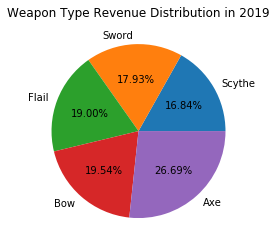

In [37]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(num1['Revenue'], labels = num1['WeaponTypename'], autopct='%.2f%%')
plt.show()

In [106]:
num2 = spark.sql("""
   SELECT MONTH(TransactionDate) as Month, Count(DISTINCT th.PlayerId) as PlayerCount 
   FROM TransactionHeader TH
   JOIN MsPlayer P ON th.PlayerId = P.PlayerId
   JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId
   JOIN MsWeapon W ON td.WeaponId = W.WeaponId
   WHERE YEAR(TransactionDate) = 2019 AND W.WeaponTypeId = 2 
   GROUP BY MONTH(TransactionDate)
   ORDER BY MONTH             
""")

In [108]:
num2 = num2.toPandas()

In [109]:
type(num2['PlayerCount'])

pandas.core.series.Series

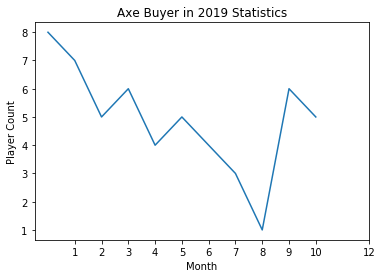

In [110]:
plt.plot(num2['PlayerCount'])
plt.xticks(num2['Month'])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [115]:
num3 = spark.sql("""
SELECT Item, COUNT(Item) as Frequency
FROM(
  SELECT PlayerId,
    (CASE
      WHEN MonthlySpending > 1000000  AND MonthlySpending < 1499999 THEN "Storm Breaker"
      WHEN MonthlySpending > 1500000 AND MonthlySpending < 1999999 THEN "Nightfall"
      ELSE "Extinction"
    END) AS Item
  FROM(
    SELECT P.PlayerId, P.PlayerGender, MONTH(TransactionDate) as MONTH, SUM(WeaponPrice*Quantity) as MonthlySpending 
    FROM MsPlayer P
    JOIN TransactionHeader TH ON P.PlayerId = TH.PlayerId
    JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId
    JOIN MsWeapon W ON TD.WeaponId = W.WeaponId
    WHERE YEAR(Transactiondate) = 2019 AND P.PlayerGender = "Female"
    GROUP BY P.PlayerId, MONTH(TransactionDate), P.playerGender
    ORDER BY MONTH
     ) x
     WHERE MonthlySpending > 1000000
   ) y
GROUP BY Item
""")

In [117]:
 num3 = num3.toPandas()

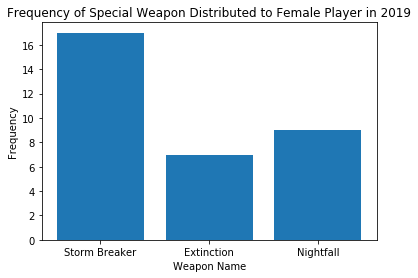

In [118]:
plt.bar(num3['Item'], num3['Frequency'])
plt.title("Frequency of Special Weapon Distributed to Female Player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [145]:
num4 = spark.sql("""
  SELECT COUNT(Playerid) as PlayerCount, Month
  FROM(
   SELECT P.PlayerId, MONTH(TransactionDate) as Month, Count(DISTINCT WeaponTypeId) as TypeCount 
   FROM TransactionHeader TH
   JOIN MsPlayer P ON TH.PlayerId = P.PlayerId
   JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId
   JOIN MsWeapon W ON TD.WeaponId = W.WeaponId
   WHERE YEAR(TransactionDate) = 2019
   GROUP BY P.PlayerId, MONTH(TransactionDate)
   ORDER BY TypeCount DESC
   )
   WHERE TypeCount >= 3
   GROUP BY Month
   ORDER BY Month       
""")

In [147]:
num4 = num4.toPandas()

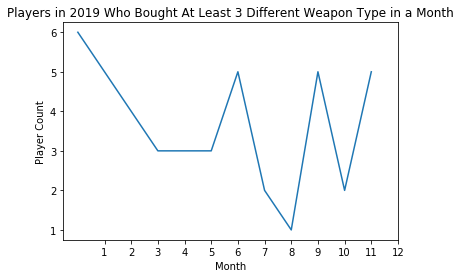

In [148]:
plt.plot(num4['PlayerCount'])
plt.xticks(num4['Month'])
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [176]:
num5 = spark.sql("""
SELECT Top, COUNT(Top) as Frequency
FROM(
  SELECT NPCId, Income,
  (CASE
      WHEN Income >= 7500000 AND Income < 14999999 THEN "Popular"
      WHEN Income >= 2500000 AND Income < 7499999 THEN "Quite Popular"
      ELSE "Very Popular"
    END) AS Top
  FROM (
   SELECT N.NPCId, SUM(WeaponPrice*Quantity) as Income, COUNT(DISTINCT th.PlayerId) as PlayerCount 
   FROM TransactionHeader TH
   JOIN MsPlayer P ON TH.PlayerId = P.PlayerId
   JOIN MsNPC N ON TH.NPCId = N.NPCId
   JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId
   JOIN MsWeapon W ON TD.WeaponId = W.WeaponId
   GROUP BY N.NPCId
   ORDER BY N.NPCId
     ) x
     
   WHERE PlayerCount >= 5 AND Income >= 2500000
   GROUP BY NPCId, Income
   ORDER BY NPCId  
) y

GROUP BY Top

""")

In [178]:
num5 = num5.toPandas()

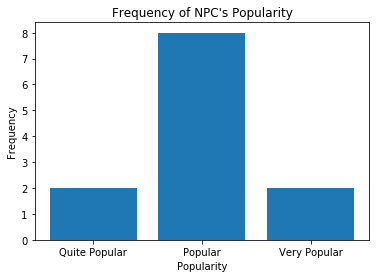

In [179]:
plt.bar(num5['Top'], num5['Frequency'])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()